# Trabajo Práctico 3

## Consigna

Entrenar un modelo de segmentación basado en la arquitectura U-Net para resolver el problema de segmentación de neumotórax. 

Los datos se pueden descargar directamente a una máquina virtual (VM) de colab desde Kaggle. El instructivo para hacerlo (tener en cuanta que hay que descargar otra vez cuando termina la sesión). 

Se usarán los datos de:

https://www.kaggle.com/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks

Reportar la métrica de Dice para un conjunto de test a definir, el mismo dataset provee de un conjunto de imágenes de testeo. Puede usarse ese conjunto o separar un conjunto propio a partir de todos los datos.

Para este TP no hay una métrica objetivo a alcanzar, se intenta en lo posible que la métrica de Dice sea lo más cercana a 1. Reportar el modelo con mejor desempeño (hiperparámetros utilizados, si se usó aumentación de datos y qué tipo de aumentación, etc...) y mostrar algunos ejemplos de segmentación. No es necesario hacer un submit a Kaggle. 

La idea es que entrenen alguna arquitectura de UNet utilizando todos los datos del dataset con anotaciones (si lo consideran necesario lo pueden reducir) y prueben hacer un entrenamiento con aumentaciones de datos que crean convenientes. Por su propia conveniencia, traten de que un entrenamiento no demore más de 30 minutos al menos que lo consideren necesario. Entregar su notebook con la descripción de qué entrenamientos intentaron, la métrica de Coeficiente de Dice obtenida en el conjunto de test y la visualización algunas (al menos 3) inferencias del modelo junto con la imagen original correspondiente y el ground truth.

## Información sobre el Dataset

This dataset contains 12,047 chest x-ray images and 12,047 pneumothorax masks. The images and masks are 1024x1024 and are in png format.

These are the folders and files:

- png_images folder
- png_masks folder
- stage1train_images.csv
- stage1test_images.csv

Each of the two csv files lists those images that were part of the original competition stage 1 train and test sets. The original image id's are also included to enable the images to be referenced back to the original competition dicom images. The target is included in both the csv files and in the name of each image and mask.

Each image and its corresponding mask have the same file name but are stored in separate folders. The naming format is as follows:

4train1_.png

4 = id

train = this image was part of the competition stage 1 train set (options are train or test)

1 = target (0 --> no pneumo, 1 --> has pneumo)

## Librerías

In [192]:
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A

from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

## Descarga de datos

In [2]:
# Instalar API de Kaggle y crear directorio y archivo para configurarla
!pip install --user kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Completar con su información de usuario de Kaggle
api_token = {'username':'lorenzavecino','key':'5ce4a5b28b8ccadff9626a2784de7aee'}

with open('/root/.kaggle/kaggle.json','w') as file:
    json.dump(api_token,file)

!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: chmod 600 ~/.kaggle/kaggle.json: No such file or directory


In [5]:
# Descargar y descomprimir dataset
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
!unzip pneumothorax-chest-xray-images-and-masks.zip

Streaming output truncated to the last 5000 lines.
  inflating: siim-acr-pneumothorax/png_masks/5912_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5913_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5914_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5915_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5916_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5917_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5918_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5919_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_test_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5920_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5921_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5922_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5923_train_0_.png  
  inflating: siim-acr-pneumothorax/png_mas

In [117]:
path = '/content/siim-acr-pneumothorax/'

In [118]:
df_train = pd.read_csv(path + 'stage_1_train_images.csv')
df_test = pd.read_csv(path + 'stage_1_test_images.csv')

In [119]:
df_train

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
...,...,...,...
10670,10670_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32459.15178751...,1
10671,10671_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,1
10672,10672_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.32730.15178751...,0
10673,10673_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.13252.15178752...,0


In [120]:
print(len(df_train[df_train.has_pneumo == 1]))

2379


In [121]:
df_test

,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
...,...,...,...
1367,1367_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7049.151787520...,0
1368,1368_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.705.1517875164...,1
1369,1369_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7050.151787520...,0
1370,1370_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.7051.151787520...,0


In [122]:
print(len(df_test[df_test.has_pneumo == 1]))

290


Hay 2379 imágenes con pneumotórax en el conjunto train y 290 en test.

In [123]:
img1 = Image.open(path + 'png_images/23_train_1_.png')
mask1 = Image.open(path + 'png_masks/23_train_1_.png')

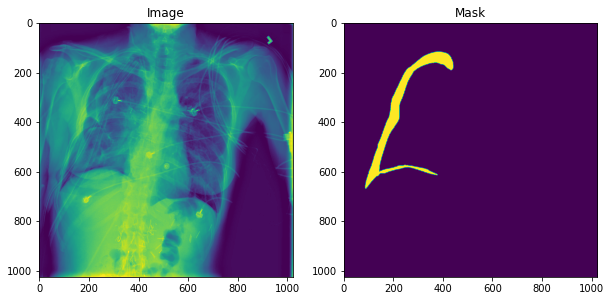

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.set_title('Image')
ax1.imshow(img1)
ax2.set_title('Mask')
ax2.imshow(mask1)
plt.show()

## Aumentación de datos

In [161]:
# Definir las transformaciones para aumentación de datos
'''

Transformaciones disponibles:
https://github.com/albumentations-team/albumentations#pixel-level-transforms

ejemplo de transformación compuesta:

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose()
])

'''

'\n\nTransformaciones disponibles:\nhttps://github.com/albumentations-team/albumentations#pixel-level-transforms\n\nejemplo de transformación compuesta:\n\ntransform = A.Compose([\n    A.RandomRotate90(),\n    A.Transpose()\n])\n\n'

Como aumentación de datos se decidió trasponer, rotar aleatoriamente 90 grados, y cambiar el contraste y brillo de forma aleatoria.

In [152]:
transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.RandomBrightnessContrast()
])

In [145]:
augmented_img1 = transform(
    image = np.array(img1.resize((256,256))).reshape(256,256,1),
    mask =  np.array(mask1.resize((256,256))).reshape(256,256,1))

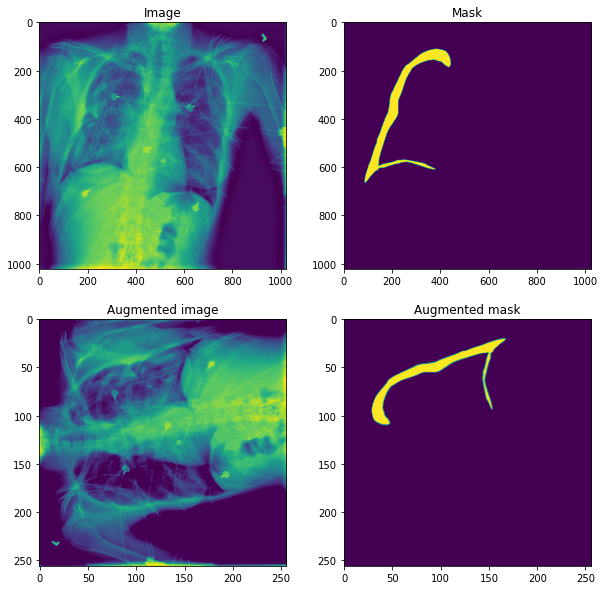

In [146]:
fig, axs = plt.subplots(2, 2, figsize = (10,10))
axs[0, 0].set_title('Image')
axs[0, 0].imshow(img1)
axs[0, 1].set_title('Mask')
axs[0, 1].imshow(mask1)
axs[1, 0].set_title('Augmented image')
axs[1, 0].imshow(augmented_img1['image'].reshape(256,256))
axs[1, 1].set_title('Augmented mask')
axs[1, 1].imshow(augmented_img1['mask'].reshape(256,256))
plt.show()

## Generador de datos

Clase DataGenerator basada en el código de:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 

In [162]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform = False, 
                 batch_size = 4, dim = (128,128), train = True, n_channels = 1, 
                 shuffle = True, mini = False):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_images/*test*1_.png")]
        self.on_epoch_end()
        if mini:
          self.filenames = self.filenames[:64]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

Se generaron 3 sets de conjutos de datos:
- datagen y datagen_val: todas las imágenes de train y test con neumotórax. Batch size de 64.
- datagen_t y datagen_val_t: todas las imágenes de train y test con neumotórax, con aumentación de datos. Batch size de 64.
- datagen_mini y datagen_val_mini: 64 imágenes de train y 64 imágenes de test, con neumotórax. Batch size de 16.

In [163]:
my_batch_size = 64
my_batch_size_mini = 16

In [164]:
# Tener cuidado con la selección del tamaño del batch. Al iniciar el entrenamiento
# dependiendo del tamaño de la red y el tamaño del batch, puede surgir un error OOM
# (out of memory) debido a las limitaciones de RAM de la GPU.
# En tal caso se deberá achicar el tamaño del batch
datagen = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = my_batch_size,
    train = True  
)

In [165]:
datagen_val = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = my_batch_size,
    train = False  
)

In [168]:
print(len(datagen))
print(len(datagen[0]))
print(len(datagen[0][0]))
print(datagen[0][0][0].shape)

37
2
64
(128, 128, 1)


In [166]:
datagen_mini = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = my_batch_size_mini,
    train = True,
    mini = True
)

In [167]:
datagen_val_mini = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = my_batch_size_mini,
    train = False,
    mini = True 
)

In [169]:
datagen_t = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = transform,
    batch_size = my_batch_size,
    train = True
)

In [170]:
datagen_val_t = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = transform,
    batch_size = my_batch_size,
    train = False  
)

Código de la función dice_coef y dice_coef_loss sacado de: https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras

In [13]:
# Definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# Función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

## Redes neuronales

Para todos los modelos se utilizó el coeficiente de Dice para la función de loss, y binary crossentropy y el coeficiente de Dice como métricas para evaluar la performance.

### Modelo secuencial sencillo

In [171]:
model_s = Sequential()
model_s.add(Conv2D(20,30, input_shape = (227,227,1), activation="relu", padding="same"))
model_s.add(Conv2D(20,30, activation="relu", padding="same"))
model_s.add(Conv2D(20,30, activation="relu", padding="same"))
model_s.add(Conv2D(1,30, activation="sigmoid", padding="same"))
model_s.compile(loss=dice_coef_loss, optimizer=Adam(1e-4))

In [172]:
model_s.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_340 (Conv2D)         (None, 227, 227, 20)      18020     
                                                                 
 conv2d_341 (Conv2D)         (None, 227, 227, 20)      360020    
                                                                 
 conv2d_342 (Conv2D)         (None, 227, 227, 20)      360020    
                                                                 
 conv2d_343 (Conv2D)         (None, 227, 227, 1)       18001     
                                                                 
Total params: 756,061
Trainable params: 756,061
Non-trainable params: 0
_________________________________________________________________


In [173]:
model_s.compile(loss = dice_coef_loss, optimizer = "adam", metrics = ["binary_crossentropy", dice_coef])

In [174]:
model_s.fit(datagen, epochs = 10, validation_data = datagen_val)

Epoch 1/10
37/37 [==============================] - 63s 2s/step - loss: 0.9670 - binary_crossentropy: 0.9594 - dice_coef: 0.0254 - val_loss: 0.8246 - val_binary_crossentropy: 0.6760 - val_dice_coef: 0.0268
Epoch 2/10
37/37 [==============================] - 66s 2s/step - loss: 0.8203 - binary_crossentropy: 0.6673 - dice_coef: 0.0267 - val_loss: 0.8162 - val_binary_crossentropy: 0.6583 - val_dice_coef: 0.0259
Epoch 3/10
37/37 [==============================] - 58s 2s/step - loss: 0.8117 - binary_crossentropy: 0.6500 - dice_coef: 0.0267 - val_loss: 0.8069 - val_binary_crossentropy: 0.6414 - val_dice_coef: 0.0275
Epoch 4/10
37/37 [==============================] - 59s 2s/step - loss: 0.8033 - binary_crossentropy: 0.6333 - dice_coef: 0.0266 - val_loss: 0.7993 - val_binary_crossentropy: 0.6248 - val_dice_coef: 0.0262
Epoch 5/10
37/37 [==============================] - 63s 2s/step - loss: 0.7952 - binary_crossentropy: 0.6170 - dice_coef: 0.0266 - val_loss: 0.7910 - val_binary_crossentropy: 0

Se obtuvo un coeficiente de Dice de 0.03 para ambos el conjunto de entrenamiento y validación, respectivamente. 

### Modelo U-Net

Código de la U-Net sacado de:
https://github.com/deeplearning-itba/segmentacion-y-autoencoders/blob/master/1%20-%20U-Net.ipynb 

In [42]:
# Definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

#### Overfitting

El primer modelo se entrenó con una versión reducida de las imágenes del dataset con el fin de observar un caso de overfitting. En este modelo 'mini' se utilizaron 64 imágenes, tanto para entrenar como para validar la red. Se usó un batch size de 16, por lo que no tenía sentido usar batchnorm. Como tiene pocas imágenes corre más rápido y se decidió usar 100 épocas.

In [175]:
# Instanciación del modelo
model_mini = UNet((128,128,1), start_ch = 32, depth = 5, batchnorm = False, residual = True, dropout = False)

In [176]:
model_mini.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_344 (Conv2D)            (None, 128, 128, 32  320         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_345 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_344[0][0]']             
                                )                                                          

In [177]:
# Compilación
model_mini.compile(loss = dice_coef_loss, optimizer = "adam", metrics = ["binary_crossentropy", dice_coef])

In [178]:
model_mini.fit(datagen_mini, epochs = 100, validation_data = datagen_val_mini)

Epoch 1/100
4/4 [==============================] - 7s 1s/step - loss: 1.4812 - binary_crossentropy: 1.9762 - dice_coef: 0.0137 - val_loss: 0.7020 - val_binary_crossentropy: 0.4350 - val_dice_coef: 0.0311
Epoch 2/100
4/4 [==============================] - 4s 955ms/step - loss: 0.7091 - binary_crossentropy: 0.4400 - dice_coef: 0.0217 - val_loss: 0.6640 - val_binary_crossentropy: 0.3586 - val_dice_coef: 0.0305
Epoch 3/100
4/4 [==============================] - 4s 974ms/step - loss: 0.6011 - binary_crossentropy: 0.2147 - dice_coef: 0.0125 - val_loss: 0.6081 - val_binary_crossentropy: 0.2165 - val_dice_coef: 2.1381e-04
Epoch 4/100
4/4 [==============================] - 3s 959ms/step - loss: 0.5483 - binary_crossentropy: 0.1002 - dice_coef: 0.0035 - val_loss: 0.5478 - val_binary_crossentropy: 0.1107 - val_dice_coef: 0.0151
Epoch 5/100
4/4 [==============================] - 4s 961ms/step - loss: 0.5391 - binary_crossentropy: 0.0875 - dice_coef: 0.0092 - val_loss: 0.5465 - val_binary_crossentr

Se obtuvo un coeficiente de Dice de 0.83 y 0.09 para los conjuntos de entrenamiento y validación, respectivamente. Esta gran diferencia entre las métricas obtenidas era de esperarse ya que con tan pocas imágenes se produce overfitting, por lo que el conjunto de datos de entrenamiento obtiene métricas muy favorables, mientras que el de validación no.

Los próximos modelos fueron entrenados con todas las imágenes de train que presentan neumotórax. Para estos se usó un batch size de 64, por lo que tampoco tenía sentido usar batchnorm. Se fue aumentando el número de épocas, utilizando 10, 20 y 30 épocas.

#### 10 épocas

In [179]:
model_10 = UNet((128,128,1), start_ch = 32, depth = 5, batchnorm = False, residual = True, dropout = False)

In [180]:
model_10.compile(loss = dice_coef_loss, optimizer = "adam", metrics = ["binary_crossentropy", dice_coef])

In [181]:
model_10.fit(datagen, epochs = 10, validation_data=datagen_val)

Epoch 1/10
37/37 [==============================] - 71s 2s/step - loss: 0.8081 - binary_crossentropy: 0.6425 - dice_coef: 0.0263 - val_loss: 0.5045 - val_binary_crossentropy: 0.0842 - val_dice_coef: 0.0752
Epoch 2/10
37/37 [==============================] - 67s 2s/step - loss: 0.4826 - binary_crossentropy: 0.0790 - dice_coef: 0.1138 - val_loss: 0.4659 - val_binary_crossentropy: 0.0775 - val_dice_coef: 0.1458
Epoch 3/10
37/37 [==============================] - 66s 2s/step - loss: 0.4545 - binary_crossentropy: 0.0847 - dice_coef: 0.1757 - val_loss: 0.4370 - val_binary_crossentropy: 0.0823 - val_dice_coef: 0.2082
Epoch 4/10
37/37 [==============================] - 66s 2s/step - loss: 0.4318 - binary_crossentropy: 0.0838 - dice_coef: 0.2202 - val_loss: 0.4130 - val_binary_crossentropy: 0.0794 - val_dice_coef: 0.2533
Epoch 5/10
37/37 [==============================] - 73s 2s/step - loss: 0.4119 - binary_crossentropy: 0.0797 - dice_coef: 0.2560 - val_loss: 0.4071 - val_binary_crossentropy: 0

Se obtuvo un coeficiente de Dice de 0.36 para ambos los conjuntos de entrenamiento y validación. Estas métricas son significativamente más altas que las del modelo secuencial sencillo, por lo que se eligió descartarlo y seguir probando con la U-Net.

In [182]:
preds_10 = model_10.predict(datagen)

37/37 [==============================] - 54s 1s/step


#### 20 épocas

In [183]:
model_20 = UNet((128,128,1), start_ch = 32, depth = 5, batchnorm = False, residual = True, dropout = False)

In [184]:
model_20.compile(loss = dice_coef_loss, optimizer = 'adam', metrics = ['binary_crossentropy', dice_coef])

In [185]:
model_20.fit(datagen, epochs = 20, validation_data = datagen_val)

Epoch 1/20
37/37 [==============================] - 71s 2s/step - loss: 0.7055 - binary_crossentropy: 0.4367 - dice_coef: 0.0257 - val_loss: 0.5022 - val_binary_crossentropy: 0.0710 - val_dice_coef: 0.0666
Epoch 2/20
37/37 [==============================] - 67s 2s/step - loss: 0.4844 - binary_crossentropy: 0.0797 - dice_coef: 0.1109 - val_loss: 0.4666 - val_binary_crossentropy: 0.0868 - val_dice_coef: 0.1536
Epoch 3/20
37/37 [==============================] - 67s 2s/step - loss: 0.4648 - binary_crossentropy: 0.0848 - dice_coef: 0.1553 - val_loss: 0.4532 - val_binary_crossentropy: 0.0856 - val_dice_coef: 0.1792
Epoch 4/20
37/37 [==============================] - 66s 2s/step - loss: 0.4430 - binary_crossentropy: 0.0855 - dice_coef: 0.1994 - val_loss: 0.4230 - val_binary_crossentropy: 0.0711 - val_dice_coef: 0.2251
Epoch 5/20
37/37 [==============================] - 67s 2s/step - loss: 0.4212 - binary_crossentropy: 0.0802 - dice_coef: 0.2379 - val_loss: 0.4081 - val_binary_crossentropy: 0

Se obtuvo un coeficiente de Dice de 0.49 y 0.39 para los conjuntos de entrenamiento y validación, respectivamente.

In [186]:
preds_20 = model_20.predict(datagen)

37/37 [==============================] - 55s 1s/step


#### 30 épocas

In [187]:
model_30 = UNet((128,128,1), start_ch = 32, depth = 5, batchnorm = False, residual = True, dropout = False)

In [188]:
model_30.compile(loss = dice_coef_loss, optimizer = 'adam', metrics = ['binary_crossentropy', dice_coef])

In [189]:
model_30.fit(datagen, epochs = 30, validation_data = datagen_val)

Epoch 1/30
37/37 [==============================] - 72s 2s/step - loss: 0.6807 - binary_crossentropy: 0.3853 - dice_coef: 0.0240 - val_loss: 0.5119 - val_binary_crossentropy: 0.0832 - val_dice_coef: 0.0594
Epoch 2/30
37/37 [==============================] - 68s 2s/step - loss: 0.4832 - binary_crossentropy: 0.0783 - dice_coef: 0.1119 - val_loss: 0.4620 - val_binary_crossentropy: 0.0900 - val_dice_coef: 0.1660
Epoch 3/30
37/37 [==============================] - 68s 2s/step - loss: 0.4553 - binary_crossentropy: 0.0843 - dice_coef: 0.1738 - val_loss: 0.4330 - val_binary_crossentropy: 0.0777 - val_dice_coef: 0.2117
Epoch 4/30
37/37 [==============================] - 67s 2s/step - loss: 0.4294 - binary_crossentropy: 0.0820 - dice_coef: 0.2231 - val_loss: 0.4458 - val_binary_crossentropy: 0.1329 - val_dice_coef: 0.2414
Epoch 5/30
37/37 [==============================] - 66s 2s/step - loss: 0.4210 - binary_crossentropy: 0.0826 - dice_coef: 0.2407 - val_loss: 0.4112 - val_binary_crossentropy: 0

Se obtuvo un coeficiente de Dice de 0.62 y 0.42 para los conjuntos de entrenamiento y validación, respectivamente. Ahora ahora los coeficientes más altos.

In [190]:
preds_30 = model_30.predict(datagen)

37/37 [==============================] - 53s 1s/step


In [195]:
preds_val_30 = model_30.predict(datagen_val)

4/4 [==============================] - 6s 1s/step


En las siguientes figuras se muestra la imagen original, la máscara original, la predicha por el modelo, y el solapamiento de la imagen original y las máscaras, para 4 imágenes con neumotórax del dataset.

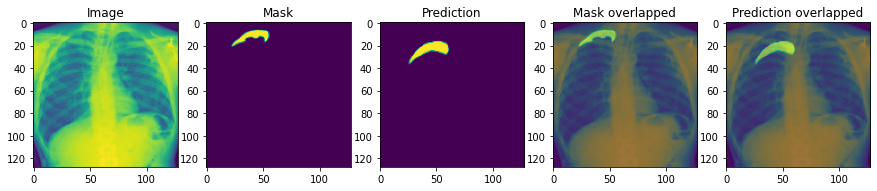

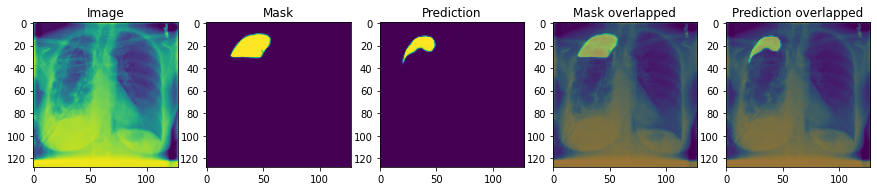

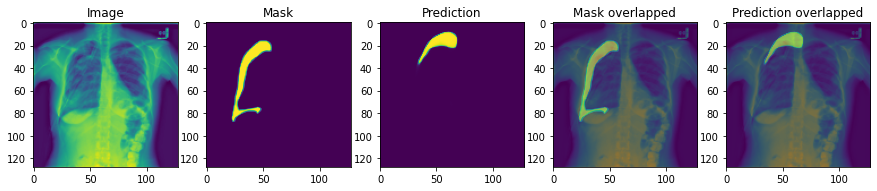

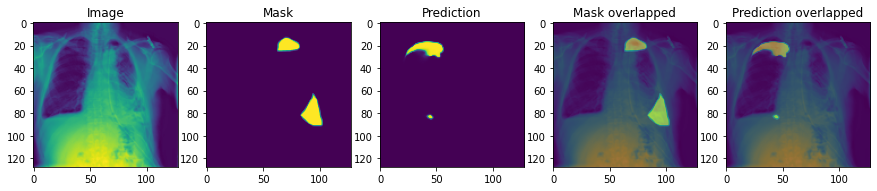

In [196]:
for i in range(0,4):
  j = random.randint(0, my_batch_size)
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (15,5))
  ax1.set_title('Image')
  ax1.imshow(datagen_val[0][0][j].reshape(128,128))
  ax2.set_title('Mask')
  ax2.imshow(datagen_val[0][1][j].reshape(128,128))
  ax3.set_title('Prediction')
  ax3.imshow(preds_val_30[j].reshape(128,128))
  ax4.set_title('Mask overlapped')
  ax4.imshow(datagen_val[0][0][j].reshape(128,128))
  ax4.imshow(datagen_val[0][1][j].reshape(128,128), alpha = 0.5)
  ax5.set_title('Prediction overlapped')
  ax5.imshow(datagen_val[0][0][j].reshape(128,128))
  ax5.imshow(preds_val_30[j].reshape(128,128), alpha = 0.5)

#### Con aumentación de datos

In [158]:
model_t = UNet((128,128,1), start_ch = 32, depth = 5, batchnorm = False, residual = True, dropout = False)

In [159]:
model_t.compile(loss = dice_coef_loss, optimizer = "adam", metrics = ["binary_crossentropy", dice_coef])

In [160]:
model_t.fit(datagen_t, epochs = 10, validation_data = datagen_val_t)

Epoch 1/10
37/37 [==============================] - 71s 2s/step - loss: 0.6358 - binary_crossentropy: 0.2902 - dice_coef: 0.0187 - val_loss: 0.5231 - val_binary_crossentropy: 0.0808 - val_dice_coef: 0.0346
Epoch 2/10
37/37 [==============================] - 68s 2s/step - loss: 0.5194 - binary_crossentropy: 0.0750 - dice_coef: 0.0361 - val_loss: 0.5164 - val_binary_crossentropy: 0.0721 - val_dice_coef: 0.0392
Epoch 3/10
37/37 [==============================] - 67s 2s/step - loss: 0.5085 - binary_crossentropy: 0.0748 - dice_coef: 0.0578 - val_loss: 0.5014 - val_binary_crossentropy: 0.0770 - val_dice_coef: 0.0743
Epoch 4/10
37/37 [==============================] - 71s 2s/step - loss: 0.5005 - binary_crossentropy: 0.0791 - dice_coef: 0.0781 - val_loss: 0.4890 - val_binary_crossentropy: 0.0697 - val_dice_coef: 0.0917
Epoch 5/10
37/37 [==============================] - 77s 2s/step - loss: 0.4813 - binary_crossentropy: 0.0843 - dice_coef: 0.1216 - val_loss: 0.4625 - val_binary_crossentropy: 0

Se obtuvo un coeficiente de Dice 0.24 y 0.26 para los conjuntos de entrenamiento y validación, respectivamente. Como dieron más bajas que las del modelo de 10 épocas sin aumentación de datos, se decidió no seguir implementando aumentación de datos.

## Conclusiones

En este trabajo se implementaron varios modelos de redes neuronales. Se probó un modelo secuencial sencillo y varios de U-Net. El coeficiente de Dice para el conjunto de validación dio mucho más alto para la U-Net de 10 épocas que para el modelo secuencial más sencillo ( 0.36 vs. 0.03), indicando que la U-Net tiene mejor performance para este problema de segmentación.

Entre los modelos de U-Net se implementaron algunos con y sin aumentación de datos. El coeficiente de Dice para el conjunto de validación dio más alto para el modelo sin aumentación de datos que para el que si tenía (0.36 vs. 0.26). Dado esto y que la aumentación de datos requiere de procesamiento adicional, se concluye que la U-Net sin aumentación de datos tienen mejor performance.

Finalmente, también se probó correr la U-Net con 10, 20 y 30 épocas. Se vio que al aumentar el número de épocas, auementaba el coeficiente de Dice. Los mejores resultados fueron obtenidos para la U-Net con 30 épocas, la cual presentó un coeficiente de Dice de 0.42 para el conjunto de datos de validación.
